# Création du maillage

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import os
#import matplotlib.pyplot as plt
#import sys, h5py, binascii

import pygimli as pg
from pygimli.meshtools import appendTriangleBoundary, merge2Meshes, mesh
from pygimli.mplviewer import drawMesh
from pygimli.viewer import showMesh
#from pygimli.meshtools.mesh import exportHDF5Mesh
#from pygimli.meshtools import convertMesh

In [3]:
#Def des paramètres de géométrie du modéle
xmin,xmax = 0, 40 # en cm
emin,emax = 0, 80 #  elevation en cm
dtrou = 30 # prof du trou en cm
etrou = emax - dtrou # elevation du fond du trou
r=2 # rayon du trou en cm
dx = .1 #On définit le pas de la maille
zaff= 20 #profondeur en cm jusqu'où on souhaite un maillage affiné. 
eaff=etrou-zaff

assert dtrou + zaff < emax

xtrou_reg = np.arange(xmin, r + dx, dx, 'float')
etrou_reg = np.arange(etrou, emax + dx, dx, 'float')


efin_reg = np.arange(eaff, etrou + dx, dx, 'float')
h_0=-95 #charge initiale en cm, soit l'état initial du sol (teneur en eau exprimée en charge)
h_1=10 #hauteur d'eau au fond du trou en cm

In [4]:
print(efin_reg)
print(etrou)

[ 30.   30.1  30.2  30.3  30.4  30.5  30.6  30.7  30.8  30.9  31.   31.1
  31.2  31.3  31.4  31.5  31.6  31.7  31.8  31.9  32.   32.1  32.2  32.3
  32.4  32.5  32.6  32.7  32.8  32.9  33.   33.1  33.2  33.3  33.4  33.5
  33.6  33.7  33.8  33.9  34.   34.1  34.2  34.3  34.4  34.5  34.6  34.7
  34.8  34.9  35.   35.1  35.2  35.3  35.4  35.5  35.6  35.7  35.8  35.9
  36.   36.1  36.2  36.3  36.4  36.5  36.6  36.7  36.8  36.9  37.   37.1
  37.2  37.3  37.4  37.5  37.6  37.7  37.8  37.9  38.   38.1  38.2  38.3
  38.4  38.5  38.6  38.7  38.8  38.9  39.   39.1  39.2  39.3  39.4  39.5
  39.6  39.7  39.8  39.9  40.   40.1  40.2  40.3  40.4  40.5  40.6  40.7
  40.8  40.9  41.   41.1  41.2  41.3  41.4  41.5  41.6  41.7  41.8  41.9
  42.   42.1  42.2  42.3  42.4  42.5  42.6  42.7  42.8  42.9  43.   43.1
  43.2  43.3  43.4  43.5  43.6  43.7  43.8  43.9  44.   44.1  44.2  44.3
  44.4  44.5  44.6  44.7  44.8  44.9  45.   45.1  45.2  45.3  45.4  45.5
  45.6  45.7  45.8  45.9  46.   46.1  46.2  46.3  4

In [5]:
etrou_reg[len(etrou_reg)-2:0:-1];

In [6]:
#A présent on crée une zone grâce à un polygone

poly = pg.Mesh(2)  # empty 2d mesh
nStart = poly.createNode(0.0, 0.0, 0.0) #On crée un noeud de départ, on travaille en 2D donc le dernier terme vaut 0.0

nA = nStart #On définit le noeud de départ

nB = poly.createNode(xmin, eaff, 0.0)
poly.createEdge(nA, nB)
nB = nA

for e in efin_reg[0:len(efin_reg)-2]: #On démarre de 1 et on se balade sur l'axe des x en créant un noeud à chaque fois
    nB = poly.createNode(0, e, 0.0)
    poly.createEdge(nA, nB) #On définit un côté entre le noeud précédemment crée et le nouveau
    nA = nB #On remplace le noeud de départ par le noeud nouvellement crée
    
nB = poly.createNode(0, etrou, 0.0) #On crée un noeud    
poly.createEdge(nA, nB)
nA = nB

#Définir les noeuds au fond du trou    
for x in xtrou_reg[0:len(xtrou_reg)-2]:
    nB = poly.createNode(x, etrou, 0.0)
    poly.createEdge(nA, nB) #On définit un côté entre le noeud précédemment crée et le nouveau
    nA = nB #On remplace le noeud de départ par le noeud nouvellement crée

nB = poly.createNode(r, etrou, 0.0) #On crée un noeud    
poly.createEdge(nA, nB)
nA = nB    
    
#Définir les noeuds le long du trou
#nA = nStart #On définit le noeud de départ
for e in etrou_reg[0:len(etrou_reg)-2]: #On démarre du haut et on se balade sur l'axe des z en créant un noeud à chaque fois
    nB = poly.createNode(r, e, 0.0)
    poly.createEdge(nA, nB) #On définit un côté entre le noeud précédemment crée et le nouveau
    nA = nB #On remplace le noeud de départ par le noeud nouvellement crée
  
nC = poly.createNode(r, emax, 0.0)
poly.createEdge(nB, nC)
nD = poly.createNode(xmax, emax, 0.0)
poly.createEdge(nC, nD)
nE = poly.createNode(xmax, emin, 0.0)
poly.createEdge(nD, nE)
poly.createEdge(nE, nStart) #On ferme le polygone!

tri = pg.TriangleWrapper(poly) #On appelle la fonction triangle
tri.setSwitches('-pzeAfaq31')
# Ici on a :
# p : planar straight line graph ==> fichier poly
# z : on démarre le comptage à 0
# A : assigne un attribut à chaque triangle qui indique à quel segment il appartient et est lié
# f : algorithme de triangulation (?)
# a : impose une surface contrainte pour chaque triangle on peut ajouter un nombre si on veut préciser
# q31 : impose que les triangles générés aient au minimun des angles de 20° O

In [7]:
#A présent on génère le maillage hétérogène

mesh = pg.Mesh(2) #On appelle le second maillage autour du premier
tri.generate(mesh) #On génère les triangles au sein du polygone précédemment crée

In [8]:
for cell in mesh.cells(): #On génère les cellules de chaque maille
    cell.setMarker(2)

In [9]:
#help(showMesh)
print()

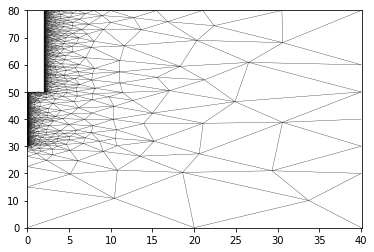

In [10]:
#fig = plt.figure()
#ax=fig.axes

ax=showMesh(mesh)


In [11]:
pg.x(pg_pos)


NameError: name 'pg_pos' is not defined

# AFFINAGE DU MAILLAGE

In [12]:
poly2=pg.Mesh(2)

In [13]:
eaff1=eaff
eaff2=65
xaff=20

eaff1_reg=np.arange(eaff1, etrou + dx, dx, 'float')
r_reg=np.arange(xmin, r + dx, dx, 'float')
eaff2_reg=np.arange(etrou, eaff2 + dx, dx, 'float')
xaff1_reg=np.arange(r, xaff + dx, dx, 'float')
xaff2_reg=np.arange(eaff1, eaff2+dx, dx, 'float')
xaff3_reg=np.arange(xmin, xaff+dx, dx, 'float')
print(xaff3_reg)

[  0.    0.1   0.2   0.3   0.4   0.5   0.6   0.7   0.8   0.9   1.    1.1
   1.2   1.3   1.4   1.5   1.6   1.7   1.8   1.9   2.    2.1   2.2   2.3
   2.4   2.5   2.6   2.7   2.8   2.9   3.    3.1   3.2   3.3   3.4   3.5
   3.6   3.7   3.8   3.9   4.    4.1   4.2   4.3   4.4   4.5   4.6   4.7
   4.8   4.9   5.    5.1   5.2   5.3   5.4   5.5   5.6   5.7   5.8   5.9
   6.    6.1   6.2   6.3   6.4   6.5   6.6   6.7   6.8   6.9   7.    7.1
   7.2   7.3   7.4   7.5   7.6   7.7   7.8   7.9   8.    8.1   8.2   8.3
   8.4   8.5   8.6   8.7   8.8   8.9   9.    9.1   9.2   9.3   9.4   9.5
   9.6   9.7   9.8   9.9  10.   10.1  10.2  10.3  10.4  10.5  10.6  10.7
  10.8  10.9  11.   11.1  11.2  11.3  11.4  11.5  11.6  11.7  11.8  11.9
  12.   12.1  12.2  12.3  12.4  12.5  12.6  12.7  12.8  12.9  13.   13.1
  13.2  13.3  13.4  13.5  13.6  13.7  13.8  13.9  14.   14.1  14.2  14.3
  14.4  14.5  14.6  14.7  14.8  14.9  15.   15.1  15.2  15.3  15.4  15.5
  15.6  15.7  15.8  15.9  16.   16.1  16.2  16.3  1

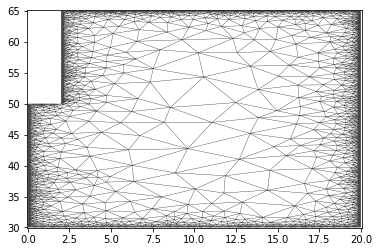

In [14]:
nStart=poly2.createNode(xmin, eaff1, 0.0)

nA=nStart
for i in eaff1_reg[0:len(eaff1_reg)-2]: #On on se balade sur l'axe des x en créant un noeud à chaque fois
    nB = poly2.createNode(xmin, i, 0.0)
    poly2.createEdge(nA, nB) #On définit un côté entre le noeud précédemment crée et le nouveau
    nA = nB #On remplace le noeud de départ par le noeud nouvellement crée
    
nB = poly2.createNode(xmin, etrou, 0.0) #On crée un noeud    
poly2.createEdge(nA, nB)
nA = nB

for i in r_reg[0:len(r_reg)-2]: #On on se balade sur l'axe des x en créant un noeud à chaque fois
    nB = poly2.createNode(i, etrou, 0.0)
    poly2.createEdge(nA, nB) #On définit un côté entre le noeud précédemment crée et le nouveau
    nA = nB #On remplace le noeud de départ par le noeud nouvellement crée
    
nB = poly2.createNode(r, etrou, 0.0) #On crée un noeud    
poly2.createEdge(nA, nB)
nA = nB
    
for i in eaff2_reg[0:len(eaff2_reg)-2]: #On on se balade sur l'axe des x en créant un noeud à chaque fois
    nB = poly2.createNode(r, i, 0.0)
    poly2.createEdge(nA, nB) #On définit un côté entre le noeud précédemment crée et le nouveau
    nA = nB #On remplace le noeud de départ par le noeud nouvellement crée
    
nB = poly2.createNode(r, eaff2, 0.0) #On crée un noeud    
poly2.createEdge(nA, nB)
nA = nB
    
for i in xaff1_reg[0:len(xaff1_reg)-2]: #On on se balade sur l'axe des x en créant un noeud à chaque fois
    nB = poly2.createNode(i, eaff2, 0.0)
    poly2.createEdge(nA, nB) #On définit un côté entre le noeud précédemment crée et le nouveau
    nA = nB #On remplace le noeud de départ par le noeud nouvellement crée   
    
nB = poly2.createNode(xaff, eaff2, 0.0) #On crée un noeud    
poly2.createEdge(nA, nB)
nA = nB
    
for i in xaff2_reg[len(xaff2_reg)-2:0:-1]: #On on se balade sur l'axe des x en créant un noeud à chaque fois
    nB = poly2.createNode(xaff, i, 0.0)
    poly2.createEdge(nA, nB) #On définit un côté entre le noeud précédemment crée et le nouveau
    nA = nB #On remplace le noeud de départ par le noeud nouvellement crée 
    
nB = poly2.createNode(xaff, eaff1, 0.0) #On crée un noeud    
poly2.createEdge(nA, nB)
nA = nB
    
for i in xaff3_reg[len(xaff3_reg)-2:0:-1]: #On on se balade sur l'axe des x en créant un noeud à chaque fois
    nB = poly2.createNode(i, eaff1, 0.0)
    poly2.createEdge(nA, nB) #On définit un côté entre le noeud précédemment crée et le nouveau
    nA = nB #On remplace le noeud de départ par le noeud nouvellement crée
    
poly2.createEdge(nA, nStart)

tri2 = pg.TriangleWrapper(poly2) #On appelle la fonction triangle
tri2.setSwitches('-pzeAfaq31')
mesh2=pg.Mesh(2)
tri2.generate(mesh2)
ax=showMesh(mesh2)


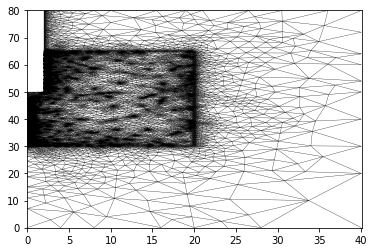

(<matplotlib.axes._subplots.AxesSubplot at 0x2387f15aeb8>, None)

In [15]:
#Ne pas oublier de fusionner les deux maillages crées
m = pg.meshtools.createMesh([mesh, mesh2]) #On crée un maillage en prenant en compte les deux maillages réalisés précédemment
#mesh2 = merge2Meshes(mesh, poly2) #Si on les fait fusionner comme ça les mailles ne sont pas recalculées et ça ne va pas
#showMesh(mesh2)
showMesh(m)

# AUTRE POSSIBILTE FAIRE UN CERCLE

In [19]:
from pygimli.meshtools import polytools as plc
import math

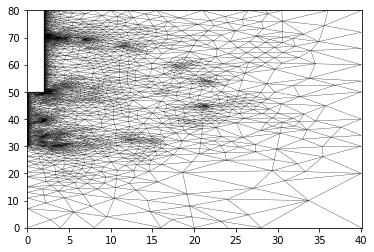

(<matplotlib.axes._subplots.AxesSubplot at 0x28f5bbcbdd8>, None)

In [53]:
c1 = plc.createCircle(pos=[r, 50], segments=12, radius=20.0, start=-math.pi/2, end=(math.pi)/2, isClosed=True)
c2=pg.meshtools.createMesh(c1)
nc1=c1.createNode(0.0, 50, 0.0)
nc2=c1.createNode(2.0, 50, 0.0)
#c1.createEdge(nc1, nc2)
#showMesh(c1)
cercle=pg.meshtools.createMesh([mesh,c1])
showMesh(cercle)

# DEFINITION DE LA POSITION DES NOEUDS

In [ ]:
pg_pos = mesh.positions()
mesh_pos = np.array((np.array(pg.x(pg_pos)), np.array(pg.y(pg_pos)), np.array(pg.z(pg_pos)))).T #On crée une matrice contenant la position des noeuds
mesh_cells = np.zeros((mesh.cellCount(), 3)) #Matrice vide de la taille du nombre de cellules
for i, cell in enumerate(mesh.cells()): #On rentre les cellules das une matrice
        mesh_cells[i] = cell.ids()

print(mesh_pos) #Permet d'afficher la position des noeuds

# INTERPOLATION DE LA CHARGE AU FOND DU TROU

In [42]:
#Création d'une fonction pour interpoler la charge au fond du trou

#Définition des paramètres initiaux
p = np.zeros((len(mesh_pos), 4), dtype = 'float')
p[:,:2] = np.array(mesh_pos[:,:2]) #coordonnées xy des noeuds du maillage
d = etrou #profondeur du trou en cm
radius = 2 #rayon du trou en cm
h_0 = -95 #charge initiale en cm, soit l'état initial du sol (teneur en eau exprimée en charge)
h_1 = 10 #hauteur d'eau au fond du trou en cm

In [43]:
def charge_trou(p,d,radius,h_0,h_1):
    
    for i in range(0,len(p)) :
        if p[i,1]==d and p[i,0]<=radius :
            p[i,2]=1
            p[i,3]=h_1
        elif p[i,1]==0 :
            p[i,2]=-3
            p[i,3]=h_0
        else :
            p[i,3]=h_0
           
charge_trou(p,d,radius,h_0,h_1)        
        
#Interpolation pour la valeur de charge au fond du trou
r = np.array(np.where((p[:,1]<=d+h_1) & (p[:,0]==radius))).T
for i in range(1,len(r)):
    p[r[i,0],2] = 1
    p[r[i,0],3] = h_1-(p[r[i,0],1]-d)

In [44]:
print(p)

[[  0.           0.          -3.         -95.        ]
 [  0.          30.           0.         -95.        ]
 [  0.          30.           0.         -95.        ]
 ..., 
 [ 40.          30.           0.         -95.        ]
 [ 10.4361316   10.78793872   0.         -95.        ]
 [ 33.71227277  10.           0.         -95.        ]]


# Définition de la matrice contenant les noeuds correspondant à chaque cellule

In [45]:
Ncells = mesh.cellCount() #nombre de cellules du maillage

t = np.zeros((Ncells, 3), dtype = 'float')
for i in range(0,Ncells) :
    c=mesh.cell(i)
    for j in range(0,3) :
        l=c.node(j)
        f=l.id()
        t[i,j]=f

In [46]:
print(t)

[[   66.    65.   868.]
 [ 1872.  1875.  1884.]
 [   94.   684.    95.]
 ..., 
 [    0.  1884.  1399.]
 [ 1880.  1883.  1881.]
 [ 1872.   523.  1885.]]


# Définition du nombre de noeuds ayant une condition aux limites

In [47]:
n_charge_imp=len(np.array(np.where(p[:,2]==1)).T)
n_free_drainage=len(np.array(np.where(p[:,2]==-3)).T)
n_total=n_charge_imp+n_free_drainage

In [48]:
print(n_charge_imp)
print(n_free_drainage)
print(n_total)

122
3
125


# Définition de la fonction width nécessaire pour Grid

In [49]:
a = (np.array(np.where(p[:,2]==1))).T #Noeuds ayant une charge imposée constante
b = (np.array(np.where(p[:,2]==-3))).T #Noeuds ayant un drainage

In [50]:
print(p[a[:,:],:])

[[[  0.   50.    1.   10. ]]

 [[  0.   50.    1.   10. ]]

 [[  0.1  50.    1.   10. ]]

 [[  0.2  50.    1.   10. ]]

 [[  0.3  50.    1.   10. ]]

 [[  0.4  50.    1.   10. ]]

 [[  0.5  50.    1.   10. ]]

 [[  0.6  50.    1.   10. ]]

 [[  0.7  50.    1.   10. ]]

 [[  0.8  50.    1.   10. ]]

 [[  0.9  50.    1.   10. ]]

 [[  1.   50.    1.   10. ]]

 [[  1.1  50.    1.   10. ]]

 [[  1.2  50.    1.   10. ]]

 [[  1.3  50.    1.   10. ]]

 [[  1.4  50.    1.   10. ]]

 [[  1.5  50.    1.   10. ]]

 [[  1.6  50.    1.   10. ]]

 [[  1.7  50.    1.   10. ]]

 [[  1.8  50.    1.   10. ]]

 [[  2.   50.    1.   10. ]]

 [[  2.   50.    1.   10. ]]

 [[  2.   50.1   1.    9.9]]

 [[  2.   50.2   1.    9.8]]

 [[  2.   50.3   1.    9.7]]

 [[  2.   50.4   1.    9.6]]

 [[  2.   50.5   1.    9.5]]

 [[  2.   50.6   1.    9.4]]

 [[  2.   50.7   1.    9.3]]

 [[  2.   50.8   1.    9.2]]

 [[  2.   50.9   1.    9.1]]

 [[  2.   51.    1.    9. ]]

 [[  2.   51.1   1.    8.9]]

 [[  2.   

In [51]:
print(a[119,0])

320


In [52]:
a

array([[201],
       [202],
       [203],
       [204],
       [205],
       [206],
       [207],
       [208],
       [209],
       [210],
       [211],
       [212],
       [213],
       [214],
       [215],
       [216],
       [217],
       [218],
       [219],
       [220],
       [221],
       [222],
       [223],
       [224],
       [225],
       [226],
       [227],
       [228],
       [229],
       [230],
       [231],
       [232],
       [233],
       [234],
       [235],
       [236],
       [237],
       [238],
       [239],
       [240],
       [241],
       [242],
       [243],
       [244],
       [245],
       [246],
       [247],
       [248],
       [249],
       [250],
       [251],
       [252],
       [253],
       [254],
       [255],
       [256],
       [257],
       [258],
       [259],
       [260],
       [261],
       [262],
       [263],
       [264],
       [265],
       [266],
       [267],
       [268],
       [269],
       [270],
       [271],
      

In [53]:
print(p)

[[  0.           0.          -3.         -95.        ]
 [  0.          30.           0.         -95.        ]
 [  0.          30.           0.         -95.        ]
 ..., 
 [ 40.          30.           0.         -95.        ]
 [ 10.4361316   10.78793872   0.         -95.        ]
 [ 33.71227277  10.           0.         -95.        ]]


In [54]:
def width(p,a,b) :
    import math
    e = np.zeros((len(a), 3), dtype = 'float')
    f = np.zeros((len(b), 3), dtype = 'float')
    e[:,0] = a[:,0]
    f[:,0] = b[:,0]
    e[:,1] = p[a[:,0],0]
    f[:,1] = p[b[:,0],0]
    
    for i in range(0,len(a[:,0])-1) :
        if i==0 : #Premier noeud
            e[i,2] = ((math.pi)/3) * ( p[a[i+1,0],0] + 2* p[a[i,0],0] * (p[a[i+1,0],0]-p[a[i,0],0]))
        elif i==(len(a[:,0])-1) : #Dernier noeud
            e[i,2] = ((math.pi)/3) * ( p[a[i-1,0],0] + 2* p[a[i,0],0] * (p[a[i,0],0]-p[a[i-1,0],0]))
        else : #Autres noeuds
            e[i,2] = ((math.pi)/3) * ( (p[a[i-1,0],0] + 2* p[a[i,0],0]) * (p[a[i,0],0]-p[a[i-1,0],0]) + (p[a[i+1,0],0] + 2* p[a[i,0],0]) * (p[a[i+1,0],0]-p[a[i,0],0]))
            
    for i in range (0,len(b[:,0])-1) :
        if i==0 :
            f[i,2] = ((math.pi)/3) * ((p[b[i+1,0],0] + 2* p[b[i,0],0]) * (p[b[i+1,0],0]-p[b[i,0],0]))
        elif i==(len(b[:,0])-1) :
            f[i,2] = ((math.pi)/3) * ((p[b[i-1,0],0] + 2* p[b[i,0],0]) * (p[b[i,0],0]-p[b[i-1,0],0]))
        else :
            f[i,2] = ((math.pi)/3) * ((p[b[i-1,0],0] + 2* p[b[i,0],0]) * (p[b[i,0],0]-p[b[i-1,0],0]) + (p[b[i+1,0],0] + 2* p[b[i,0],0]) * (p[b[i+1,0],0]-p[b[i,0],0]))
    
    return e , f #Permet de retourner e et f pour s'en servir après

In [55]:
e, f = width(p,a,b)

In [56]:
print(e)

[[  2.01000000e+02   0.00000000e+00   0.00000000e+00]
 [  2.02000000e+02   0.00000000e+00   1.04719755e-02]
 [  2.03000000e+02   1.00000000e-01   6.28318531e-02]
 [  2.04000000e+02   2.00000000e-01   1.25663706e-01]
 [  2.05000000e+02   3.00000000e-01   1.88495559e-01]
 [  2.06000000e+02   4.00000000e-01   2.51327412e-01]
 [  2.07000000e+02   5.00000000e-01   3.14159265e-01]
 [  2.08000000e+02   6.00000000e-01   3.76991118e-01]
 [  2.09000000e+02   7.00000000e-01   4.39822972e-01]
 [  2.10000000e+02   8.00000000e-01   5.02654825e-01]
 [  2.11000000e+02   9.00000000e-01   5.65486678e-01]
 [  2.12000000e+02   1.00000000e+00   6.28318531e-01]
 [  2.13000000e+02   1.10000000e+00   6.91150384e-01]
 [  2.14000000e+02   1.20000000e+00   7.53982237e-01]
 [  2.15000000e+02   1.30000000e+00   8.16814090e-01]
 [  2.16000000e+02   1.40000000e+00   8.79645943e-01]
 [  2.17000000e+02   1.50000000e+00   9.42477796e-01]
 [  2.18000000e+02   1.60000000e+00   1.00530965e+00]
 [  2.19000000e+02   1.70000

In [57]:
import math
(math.pi)*(-0.06)

-0.18849555921538758

# ECRITURE DU FICHIER SELECTOR.IN 

In [58]:
param = [0.06, 0.3, 0.06, 0.3, 0.016, 8.52, 0.07, 0.07, 0.3]
temps=[0.17, 0.33, 0.50, 0.67, 0.83, 1.00, 1.17, 1.33, 1.50, 1.67, 1.83, 2.00, 2.17, 2.33, 2.50, 2.67, 2.83, 3.00, 3.17, 3.33, 3.50, 3.67, 3.83, 4.00]

paramlist=" ".join([str(i) for i in param])
tempslist=" ".join([str(i) for i in temps])

s = """
*** BLOCK A: BASIC INFORMATION *****************************************
'Heading'
Example 1 - Column Test
LUnit  TUnit  MUnit  BUnit     (units are obligatory for all input data)
 'cm'   'min'  '-'    '-'
Kat (0:horizontal plane, 1:axisymmetric vertical flow, 2:vertical plane
1
MaxIt   TolTh   TolH       (maximum number of iterations and tolerances)
  21    .001   0.5
lWat    lChem   ChecF   ShortF  FluxF   AtmInF  SeepF  FreeD  DrainF
 t  f  f      t       t       f       f      t      f
*** BLOCK B: MATERIAL INFORMATION **************************************
NMat    NLay    hTab1   hTabN   NPar
  1      1      .001    200.     9
thr     ths     tha     thm     Alfa    n       Ks      Kk      thk
 {}
*** BLOCK C: TIME INFORMATION ******************************************
dt      dtMin   dtMax   DMul    DMul2   MPL
 .1    .01     10.     1.1     .7     24
TPrint(1),TPrint(2),...,TPrint(MPL)                   (print-time array)
   {}
*** END OF INPUT FILE SELECTOR.IN************************************
""".format(paramlist,tempslist)

In [59]:
fselector=open("Selector.in","w")

fselector.write(s)

fselector.close()

In [60]:
!cat Selector.in

'cat' n’est pas reconnu en tant que commande interne
ou externe, un programme exécutable ou un fichier de commandes.


# ECRITURE DU FICHIER GRID.IN

In [61]:
Ncells = mesh.cellCount() #nombre de cellules du maillage
Nnodes = mesh.nodeCount() #nombre de noeuds du maillage
Nbc = n_total #nombre de noeuds avec Boundary conditions. A DEFINIR AVEC CLEMENCE!!
Nnodes, Ncells, Nbc

(1886, 3216, 125)

In [62]:
dim = [Nnodes, Ncells, 2, Nbc, 0]

dim_list=" ".join([str(i) for i in dim])

s1 = """
*** BLOCK H: NODAL INFORMATION **************************************************
      NumNP     NumEl       IJ      NumBP     NObs
   {}
   n  Code    x      z          h       Conc      Q     M   B    Axz   Bxz   Dxz
""".format(dim_list)

s2 = """
*** BLOCK I: ELEMENT INFORMATION ************************************************
   e   i   j   k   l   Angle  Aniz1  Aniz2  LayNum
"""

s3="""
*** BLOCK J: BOUNDARY GEOMETRY INFORMATION *************************************
    Node number array:
"""

In [63]:
fgrid=open("Grid.in","w")

fgrid.write(s1)

#code = p[:,2] #A définir par clemence pour chaque node
#h = p[:,3]  #A definir par clemence pour chaque node

# for i in np.arange(Nnodes):
#   fgrid.write("""{} {} {} {} {} .00E+00 .00E+00 1 0 1 1 1 \n""".format(i + 1, code, node.x(i), node.y(i), h)) 

for i in range(0,len(p)) :
   fgrid.write("""{} {} {} {} {} .00E+00 .00E+00 1 0 1 1 1 \n""".format(i + 1, int(p[i,2]), round(p[i,0],2), round(p[i,1],2), round(p[i,3],2)))
    
#Attention, il faut enlever une ligne mais je ne vois pas comment faire...
fgrid.write(s2)

for i in range(0,len(t)) :
   fgrid.write("""{} {} {} {} {} 0 1 1 1 \n""".format(i + 1, int(t[i,0]), int(t[i,1]), int(t[i,2]), int(t[i,2])))

fgrid.write(s3)

k = 1

for i in range(0,len(e[:,0])) :
   fgrid.write("""{} \t""".format(int(e[i,0])))
   k = k + 1
   if k==7 :
      fgrid.write("""\n""")
      k = 1
        
k = 1

fgrid.write("""\n""")
for i in range(0,len(f[:,0])) :
   fgrid.write("""{} \t""".format(int(f[i,0])))
   k = k + 1
   if i==7 :
        fgrid.write("""\n""")
        k = 1

k = 1 

fgrid.write("""\n""")
fgrid.write("""Width array:\n""")
for i in range(0,len(e[:,0])) :
   fgrid.write("""{} \t""".format(e[i,2]))
   k = k + 1
   if i==7 :
        fgrid.write("""\n""")
        k = 1
    
fgrid.write("""\n""")

k = 1 

for i in range(0,len(f[:,0])) :
   fgrid.write("""{} \t""".format(int(f[i,2])))
   k = k + 1
   if i==7 :
        fgrid.write("""\n""")
        k=1

fgrid.write("""\n""")
fgrid.write("""Length:\n""")
fgrid.write("""0\n""")

fgrid.write("""*** END OF INPUT FILE GRID.IN *************************************************\n""")

fgrid.close()

In [64]:
!tail -10000 Grid.in

'tail' n’est pas reconnu en tant que commande interne
ou externe, un programme exécutable ou un fichier de commandes.


In [ ]:
import os
import sys
from os import chdir


#path_SWMS="/home/chouze/Kriterres/TESTS_CLEM"
path_SWMS="C:/Users/Euette/Documents/SWMS_2D/"

chdir(path_SWMS)

#cmd=os.system("./home/chouze/Codes/HD2/H2D")
#cmd=os.system("C:\Users\Euette\Documents\SWMS_2D\swms_2d")
os.startfile(r'swms_2d.exe')



# TESTS ET EXEMPLES

In [27]:
c=mesh.cell(0) #On appelle c l'une des cellules
print(c) #Affiche toutes les infos sur cette cellule
l=c.node(2) #On sélectionne la dernière node de la cellule c que l'on appelle l
l.id() #On affiche le noeud correspondant à l
c.node(0) == mesh.node(559) #On vérifie que la première node de c correspond au noeud numéro 559 du maillage
for node in c.nodes(): #On crée une boucle qui sélectionne un par un tous les noeuds de c
    f=node.id()
    print(f) #On affiche à chaque fois le numéro du noeud

<class 'pygimli.core._pygimli_.Triangle'>	ID: 0, Marker: 2, Size: 0.010716723699152081
	559 RVector3: (0.171279466666, 38.85, 0.0)
	685 RVector3: (0.107533776285, 38.75, 0.0)
	1041 RVector3: (0.269366180869, 38.667638244899, 0.0)

559
685
1041


Mesh: Nodes: 6321 Cells: 6000 Boundaries: 12320
No valid data:  1 1 False


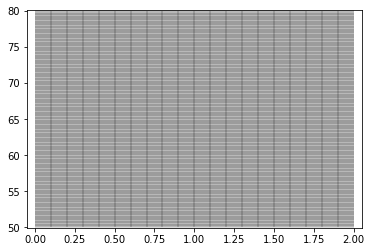

(<matplotlib.axes._subplots.AxesSubplot at 0x7f47a3368978>, None)

In [10]:
#Ici on commence par définir un maillage rectangulaire homogène

dtrou = 30 #Profondeur du trou

xmin, xmax = 0., 2 #On définit les limites en x du maillage
zmin, zmax = 50 , 80 #On définit les limites en z du maillage

dx = 0.1 #On définit le pas de la maille
xreg = np.arange(xmin, xmax + dx, dx, 'float') #On calcule les coordonées des mailles
zreg = np.arange(zmin, zmax + dx, dx, 'float')

mesh1 = pg.Mesh(2) #On crée un maillage vide 
mesh1.create2DGrid(xreg, zreg, 0) #On crée le maillage
for c in mesh1.cells(): #On marque les cellules
    c.setMarker(1)

print(mesh1) #On affiche le mombre de noeuds, cellules et lignes

#showMesh(mesh1, mesh1.cellMarkers(), logScale=False, label="Region marker") #On définit les paramètres d'affichage

showMesh(mesh1, mesh1.cellMarkers(), label="Region marker")
#drawMesh(ax,mesh1)

In [5]:
#A présent on crée une zone grâce à un polygone

poly = pg.Mesh(2)  # empty 2d mesh
nStart = poly.createNode(2, zmax, 0.0) #On crée un noeud de départ, on travaille en 2D donc le dernier terme vaut 0.0

nA = nStart #On définit le noeud de départ
for z in zreg[1:]: #On démarre de 1 et on se balade sur l'axe des x en créant un noeud à chaque fois
    nB = poly.createNode(2, z, 0.0)
    poly.createEdge(nA, nB) #On définit un côté entre le noeud précédemment crée et le nouveau
    nA = nB #On remplace le noeud de départ par le noeud nouvellement crée

z2 = 30 #On définit une altitude z2
nA = poly.createNode(xmax, z2, 0.0) #On crée un noeud
poly.createEdge(nB, nA) #On fait le lien entre le dernier noeud crée et celui-là
nB = poly.createNode(xmin, z2, 0.0) #On crée un autre noeud en symétrique
poly.createEdge(nA, nB) #On fait le lien avec le noeud précédent
nC = poly.createNode(xmin, 80, 0.0)
poly.createEdge(nB, nC)
nD = poly.createNode(40, 80, 0.0)
poly.createEdge(nC, nD)
nE = poly.createNode(40, 0.0, 0.0)
poly.createEdge(nD, nE)
poly.createEdge(nE, nStart) #On ferme le polygone!

tri = pg.TriangleWrapper(poly) #On appelle la fonction triangle
tri.setSwitches('-pzeAfaq31') #On rentre tout un tas de commandes rigolotes pour générer les triangles
# Ici on a :
# p : planar straight line graph ==> fichier poly
# z : on démarre le comptage à 0
# A : assigne un attribut à chaque triangle qui indique à quel segment il appartient et est lié
# f : algorithme de triangulation (?)
# a : impose une surface contrainte pour chaque triangle on peut ajouter un nombre si on veut préciser
# q31 : impose que les triangles générés aient au minimun des angles de 20° On peut ajouter un nombre derrière pour préciser le nombre que l'o souhaite

In [6]:
#A présent on génère le maillage hétérogène

mesh2 = pg.Mesh(2) #On appelle le second maillage autour du premier
tri.generate(mesh2) #On génère les triangles au sein du polygone précédemment crée

for cell in mesh2.cells(): #On génère les cellules de chaque maille
    cell.setMarker(2)

No valid data:  1 1 False


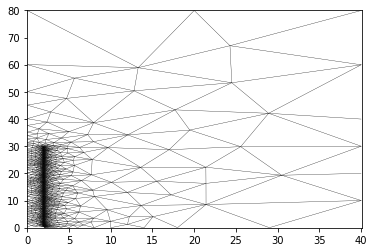

In [7]:
#Fusion des deux maillages pour créer un maillage hybride
#mesh3 = merge2Meshes(mesh1, mesh2) #On peut faire fusionner les deux maillages ainsi crées en un seul

a=showMesh(mesh2, mesh1.cellMarkers(), label="Region marker")

In [ ]:
#Test à effacer
#pg.meshtools.writePLC(mesh2, 'Test')
#read2d = pg.meshtools.readPLC('Test')
#print(read2d)

In [18]:
pg_pos = mesh2.positions()
mesh_pos = np.array((np.array(pg.x(pg_pos)), np.array(pg.y(pg_pos)), np.array(pg.z(pg_pos)))).T #On crée une matrice contenant la position des noeuds
mesh_cells = np.zeros((mesh2.cellCount(), 3)) #Matrice vide de la taille du nombre de cellules
for i, cell in enumerate(mesh2.cells()): #On rentre les cellules das une matrice
        mesh_cells[i] = cell.ids()


In [19]:
print(mesh_pos) #Permet d'afficher la position des noeuds

[[ 0.02        0.          0.        ]
 [ 0.02        0.01        0.        ]
 [ 0.02        0.02        0.        ]
 [ 0.02        0.03        0.        ]
 [ 0.02        0.04        0.        ]
 [ 0.02        0.05        0.        ]
 [ 0.02        0.06        0.        ]
 [ 0.02        0.07        0.        ]
 [ 0.02        0.08        0.        ]
 [ 0.02        0.09        0.        ]
 [ 0.02        0.1         0.        ]
 [ 0.02        0.11        0.        ]
 [ 0.02        0.12        0.        ]
 [ 0.02        0.13        0.        ]
 [ 0.02        0.14        0.        ]
 [ 0.02        0.15        0.        ]
 [ 0.02        0.16        0.        ]
 [ 0.02        0.17        0.        ]
 [ 0.02        0.18        0.        ]
 [ 0.02        0.19        0.        ]
 [ 0.02        0.2         0.        ]
 [ 0.02        0.21        0.        ]
 [ 0.02        0.22        0.        ]
 [ 0.02        0.23        0.        ]
 [ 0.02        0.24        0.        ]
 [ 0.02        0.25      

In [20]:
mesh2.boundaries() #utiliser la tabulation pour lister les operations possibles sur un objet. mesh.'tab par exemple
mesh2.cellCount()
a=np.array([1,2])
np.cross(a,a)

array(0)

In [21]:
for c in mesh2.cells(): #Afficher les coordonnées des noeuds pour chaque cellule
    print([[node.x(),node.y()] for node in c.nodes()])

[[0.030753377629, 0.125], [0.028863965212, 0.11499999999999999], [0.042251767961, 0.11764898589]]
[[0.046053321247, 0.295179081859], [0.063049919249, 0.28669442703], [0.053572217547, 0.311660876279]]
[[0.038493467406, 0.059804062892], [0.028863965212, 0.065], [0.028662594877, 0.055]]
[[0.030753377629, 0.075], [0.028863965212, 0.065], [0.038493467406, 0.059804062892]]
[[0.02, 0.03], [0.028662594877, 0.024999999999999998], [0.028863965212, 0.034999999999999996]]
[[0.028863965212, 0.11499999999999999], [0.02, 0.12], [0.02, 0.11]]
[[0.02, 0.22999999999999998], [0.030753377629, 0.235], [0.02, 0.24]]
[[0.04423707694, 0.037273879146], [0.050934599579, 0.024417257578], [0.054635685292999996, 0.048822560234]]
[[0.032894100352, 0.31233323692799997], [0.021497852689, 0.341239287254], [0.014590164408, 0.318562705221]]
[[0.030753377629, 0.075], [0.037127946667, 0.08499999999999999], [0.02, 0.08]]
[[0.028662594877, 0.024999999999999998], [0.02, 0.03], [0.02, 0.02]]
[[0.04683593292, 0.263581081545], 

In [22]:
#c=mesh.cell(0) renvoie la cellule 0

def crossprod(c): #Fonction pour vérifier sur les triangles sont dans le bon ordre

    node0=c.node(0)
    a0=np.array([node0.x(),node0.y()])
    node1=c.node(1)
    a1=np.array([node1.x(),node1.y()])
    node2=c.node(2)
    a2=np.array([node2.x(),node2.y()])

    #faire un produit vectoriel entre node[1]-node[0] et node[2]-node[0]. 
    return np.cross(a1-a0,a2-a0)

crossprod(mesh2.cell(0))
# si négatif, node[1],node[2]=node[2],node[1]
# afficher node[0] node[1] node[2]
#c.boundaryNodes

array(0.0001288730006569763)

In [23]:
f=open("maillage.txt","w") #On écrit la position des noeuds dans un fichier texte

for c in mesh2.cells(): 
    assert crossprod(c) > 0 # arrete tout si c'est faux.
    for node in c.nodes():
        #f.write(str([[node.x(),node.y()]]))
        f.write("{} {} \n".format(node.x(),node.y()))
f.close()

In [24]:
!cat maillage.txt

0.030753377629 0.125 
0.028863965212 0.11499999999999999 
0.042251767961 0.11764898589 
0.046053321247 0.295179081859 
0.063049919249 0.28669442703 
0.053572217547 0.311660876279 
0.038493467406 0.059804062892 
0.028863965212 0.065 
0.028662594877 0.055 
0.030753377629 0.075 
0.028863965212 0.065 
0.038493467406 0.059804062892 
0.02 0.03 
0.028662594877 0.024999999999999998 
0.028863965212 0.034999999999999996 
0.028863965212 0.11499999999999999 
0.02 0.12 
0.02 0.11 
0.02 0.22999999999999998 
0.030753377629 0.235 
0.02 0.24 
0.04423707694 0.037273879146 
0.050934599579 0.024417257578 
0.054635685292999996 0.048822560234 
0.032894100352 0.31233323692799997 
0.021497852689 0.341239287254 
0.014590164408 0.318562705221 
0.030753377629 0.075 
0.037127946667 0.08499999999999999 
0.02 0.08 
0.028662594877 0.024999999999999998 
0.02 0.03 
0.02 0.02 
0.04683593292 0.263581081545 
0.037127946667 0.245 
0.059522235177999996 0.245126330064 
0.028662594877 0.175 
0.037127946667 0.165 
0.038493467

In [25]:
#pg.x? #Permet d'avoir des infos grâce à ?

In [26]:
l=list(pg_pos)
l[1]
list(l[1])

[0.02, 0.01, 0.0]

In [27]:
mesh2.saveAscii('mesh.a')

1

In [28]:
#Création d'une fonction pour interpoler la charge au fond du trou

#Définition des paramètres initiaux
p = np.array(mesh_pos[:,:2]) #coordonnées xy des noeuds du maillage
d = 30 #profondeur du trou en cm
radius = 2 #rayon du trou en cm
h_0 = -95 #charge initiale en cm, soit l'état initial du sol (teneur en eau exprimée en charge)
h_1 = 10 #hauteur d'eau au fond du trou en cm


In [29]:
b = np.where(p[:,1]==0)


In [31]:
def charge_trou(p,d,radius,h_0,h_1):
    
    for i in range(1,len(p)) :
        if p[i,1]==d & p[i,0]<=radius :
            p[i,2]=1
            p[i,3]=h_1
        elif p[i,1]==0 :
            p[i,2]=-3
            p[i,3]=h_0
        else :
            p[i,3]=h_0

#Interpolation pour la valeur de charge au fond du trou
r = np.where((p[:,1]<=d+h_1)) #& np.where(p[:,0]==radius)
for i in range(1,len(r)) :
    p[r(i),2] = 1
    p[r(i),3] = h_1-(p[r(i),1]-d)
        
        

In [32]:
print(p)

[[ 0.02        0.        ]
 [ 0.02        0.01      ]
 [ 0.02        0.02      ]
 [ 0.02        0.03      ]
 [ 0.02        0.04      ]
 [ 0.02        0.05      ]
 [ 0.02        0.06      ]
 [ 0.02        0.07      ]
 [ 0.02        0.08      ]
 [ 0.02        0.09      ]
 [ 0.02        0.1       ]
 [ 0.02        0.11      ]
 [ 0.02        0.12      ]
 [ 0.02        0.13      ]
 [ 0.02        0.14      ]
 [ 0.02        0.15      ]
 [ 0.02        0.16      ]
 [ 0.02        0.17      ]
 [ 0.02        0.18      ]
 [ 0.02        0.19      ]
 [ 0.02        0.2       ]
 [ 0.02        0.21      ]
 [ 0.02        0.22      ]
 [ 0.02        0.23      ]
 [ 0.02        0.24      ]
 [ 0.02        0.25      ]
 [ 0.02        0.26      ]
 [ 0.02        0.27      ]
 [ 0.02        0.28      ]
 [ 0.02        0.29      ]
 [ 0.02        0.3       ]
 [ 0.02        0.3       ]
 [ 0.          0.3       ]
 [ 0.          0.8       ]
 [ 0.4         0.8       ]
 [ 0.4         0.        ]
 [ 0.27        0.        ]
 

In [100]:
g=np.where()

AttributeError: 'numpy.ndarray' object has no attribute 'index'

In [110]:
print(mesh2.cell(0))

<class 'pygimli.core._pygimli_.Triangle'>	ID: 0, Marker: 2, Size: 4.904335710250004e-05
	51 RVector3: (0.010753377629, -0.285, 0.0)
	1 RVector3: (0.0, -0.29, 0.0)
	36 RVector3: (0.008863965212, -0.295, 0.0)



In [119]:

c=mesh2.cell(0)
for node in c.nodes():
   print(node.i

ArgumentError: Python argument types in
    Node.pos(Node, int)
did not match C++ signature:
    pos(GIMLI::Node {lvalue})
    pos(GIMLI::Node {lvalue})